# Network Capacity
In deep learning, the number of learnable parameters in a model is often referred to as the model’s **capacity**. Intuitively, a model with more parameters has more **memorization capacity** and therefore can easily learn a perfect dictionary-like mapping between training samples and their targets—a mapping without any generalization power.

If the network has limited memorization resources, it won’t be able to learn this mapping as easily; thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets—precisely the type of representations we’re interested in.

The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and increase the size of the layers or add new layers until you see diminishing returns with regard to validation loss. Let’s try this on the movie-review classification network. The original network is shown first.

In [1]:
from keras.datasets import imdb

(train_data, train_labels),(test_data, test_labels) = imdb.load_data(num_words=10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

In [2]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [3]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [4]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Original model

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

## Version of model with lower capacity

In [7]:
model_low_cap = models.Sequential()
model_low_cap.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
model_low_cap.add(layers.Dense(4, activation='relu'))
model_low_cap.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model_low_cap.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

As one might expect, the version of the model with lower capacity will start overfitting later than the reference network, and its performance degrades more slowly once it does start overfitting.

In the same vein, a network with much more capacity will begin overfitting almost immediately, and overfits much more severely. Its validation loss is also likely to be noisier.

# Adding weight regularization
Given some training data and a network architecture, multiple sets of weight values (multiple models) *could* explain the data. Which one should we choose? As it turns out, simpler models are less likely to over-fit than complex ones.

A **simple model** in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to take only small values, which makes the distribution of weight values more regular. **This is called weight regularization, and it’s done by adding to the loss function of the network a cost associated with having large weights.** This cost comes in two flavors:

- **L1 regularization**—The cost added is proportional to the *absolute value of the weight coefficients* (the L1 norm of the weights).
- **L2 regularization**—The cost added is proportional to the *square of the value of the weight coefficients* (the L2 norm of the weights). L2 regularization is also called **weight decay** in the context of neural networks.


In Keras, weight regularization is added by passing **weight regularizer instances** to layers as keyword arguments. Let’s add L2 weight regularization to the movie-review classification network.

In [9]:
from keras import regularizers


reg_model = models.Sequential()
reg_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                       activation='relu', input_shape=(10000,)))
reg_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                       activation='relu'))
reg_model.add(layers.Dense(1, activation='sigmoid'))

`l2(0.001)` means every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of the network. Note that because this penalty is *only added at training time*, the loss for this network will be much higher at training than at test time.

In [10]:
reg_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
x_val = x_train[:10000] # Set aside first 10,000 samples for validation
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [12]:
history1 = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val)
)

history2 = reg_model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/20
118/118 [==============================] - 1s 8ms/step - loss: 0.5231 - accuracy: 0.7649 - val_loss: 0.3297 - val_accuracy: 0.8649
Epoch 2/20
118/118 [==============================] - 1s 4ms/step - loss: 0.2221 - accuracy: 0.9205 - val_loss: 0.2926 - val_accuracy: 0.8842
Epoch 3/20
118/118 [==============================] - 1s 4ms/step - loss: 0.1516 - accuracy: 0.9487 - val_loss: 0.3122 - val_accuracy: 0.8831
Epoch 4/20
118/118 [==============================] - 1s 5ms/step - loss: 0.1121 - accuracy: 0.9636 - val_loss: 0.3282 - val_accuracy: 0.8832
Epoch 5/20
118/118 [==============================] - 1s 4ms/step - loss: 0.0890 - accuracy: 0.9708 - val_loss: 0.3856 - val_accuracy: 0.8733
Epoch 6/20
118/118 [==============================] - 1s 4ms/step - loss: 0.0681 - accuracy: 0.9782 - val_loss: 0.4381 - val_accuracy: 0.8738
Epoch 7/20
118/118 [==============================] - 1s 4ms/step - loss: 0.0514 - accuracy: 0.9828 - val_loss: 0.4863 - val_accuracy: 0.8699
Epoch 

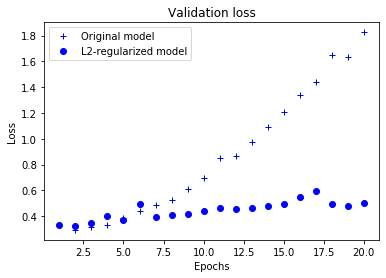

In [13]:
import matplotlib.pyplot as plt

history1_dict = history1.history
history2_dict = history2.history

val_loss_values1 = history1_dict['val_loss']
val_loss_values2 = history2_dict['val_loss']

epochs = range(1,len(val_loss_values1) + 1)

plt.plot(epochs, val_loss_values1, 'b+', label='Original model')
plt.plot(epochs, val_loss_values2, 'bo', label='L2-regularized model')


plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), even though both models have the same number of parameters.

As an alternative to L2 regularization, you can use one of the following Keras weight regularizers.

```python

# L1 regularization
regularizers.l1(0.001)

# Simultaneous L1 and L2 regularization
regularizers.l1_l2(l1=0.001, l2=0.001)
```

## Adding dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks. Dropout, applied to a layer, consists of randomly dropping out (setting to zero) a number of output features of the layer during training.

The *dropout rate* is the fraction of the features that are zeroed out; it’s usually set between $0.2$ and $0.5$. At test time, no units are dropped out; instead, the layer’s output values are scaled down by a factor equal to the dropout rate, to balance for the fact that more units are active than at training time.

This technique may seem strange and arbitrary. Why would this help reduce overfitting? The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant, which the network will start memorizing if no noise is present.

In Keras, you can introduce dropout in a network via the Dropout layer, which is applied to the output of the **layer right before** it.:
`model.add(layers.Dropout(0.5))`

Let’s add two `Dropout` layers in the IMDB network to see how well they do at reducing overfitting.

In [14]:
drp_model = models.Sequential()
drp_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
drp_model.add(layers.Dropout(0.5))
drp_model.add(layers.Dense(16, activation='relu'))
drp_model.add(layers.Dropout(0.5))
drp_model.add(layers.Dense(1, activation='sigmoid'))

drp_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history2 = drp_model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/20
118/118 [==============================] - 1s 7ms/step - loss: 0.6395 - accuracy: 0.6086 - val_loss: 0.4085 - val_accuracy: 0.8683
Epoch 2/20
118/118 [==============================] - 1s 5ms/step - loss: 0.4281 - accuracy: 0.8284 - val_loss: 0.3170 - val_accuracy: 0.8878
Epoch 3/20
118/118 [==============================] - 1s 5ms/step - loss: 0.3280 - accuracy: 0.8832 - val_loss: 0.2797 - val_accuracy: 0.8937
Epoch 4/20
118/118 [==============================] - 1s 5ms/step - loss: 0.2565 - accuracy: 0.9124 - val_loss: 0.2892 - val_accuracy: 0.8926
Epoch 5/20
118/118 [==============================] - 1s 5ms/step - loss: 0.2310 - accuracy: 0.9206 - val_loss: 0.3210 - val_accuracy: 0.8904
Epoch 6/20
118/118 [==============================] - 1s 5ms/step - loss: 0.2034 - accuracy: 0.9294 - val_loss: 0.3154 - val_accuracy: 0.8868
Epoch 7/20
118/118 [==============================] - 1s 5ms/step - loss: 0.1894 - accuracy: 0.9375 - val_loss: 0.3502 - val_accuracy: 0.8880
Epoch 

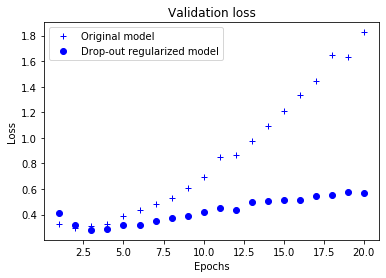

In [16]:
history1_dict = history1.history
history2_dict = history2.history

val_loss_values1 = history1_dict['val_loss']
val_loss_values2 = history2_dict['val_loss']

epochs = range(1,len(val_loss_values1) + 1)

plt.plot(epochs, val_loss_values1, 'b+', label='Original model')
plt.plot(epochs, val_loss_values2, 'bo', label='Drop-out regularized model')


plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Again, this is a clear improvement over the reference network.

To recap, these are the most common ways to prevent overfitting in neural networks:
- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout.
